In [3]:
import os
import random

import numpy as np
import pandas as pd

from tensorflow import keras
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from mlp_explainer.synthetic_data import SyntheticData, split_data, sample_datapoints
from mlp_explainer.explainer import MLPExplainer, draw_network, markov_blanket

#### 1. Define Ground Truth Bayesian Network

In [4]:
identifier = 'experiment_1'
experiment = SyntheticData(identifier)

#### 2. Sample Sufficient Dataset From Ground Truth Bayesian Network

In [5]:
experiment.create_dataset()
experiment.save()

Ground-truth for experiment_1 dataset already exists.
Ground-truth experiment_1 ground truth network already exists.


In [6]:
data = pd.read_csv(f'data/{identifier}_ground_data.csv')

#### 3. Choose Target Variable From Bayesian Network Variables And Preprocess Data

In [7]:
X, y, target_node = split_data(experiment.model, data)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, shuffle=True
)

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

def process_data(x_data):
    x_data = scaler.transform(x_data)
    return x_data

X_train = process_data(X_train)
X_test = process_data(X_test)

#### 4. MLP Model Building And Training

In [9]:
model = keras.models.Sequential([
    keras.Input(shape = (X_train.shape[1],)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(32, activation = 'sigmoid'),
    keras.layers.Dense(8, activation = 'relu'),
    keras.layers.Dense(1)  
])

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = 'mse')

history = model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2)

Epoch 1/10


2025-09-21 14:54:25.240007: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0194 - val_loss: 0.0051
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0050 - val_loss: 0.0048
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 0.0047 - val_loss: 0.0042
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 0.0045 - val_loss: 0.0041
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 9/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.0043 - val_loss: 0.0038
Epoch 10/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042 - val_loss: 0.0038


In [10]:
loss = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)

print(f"R² score: {r2:.4f}")
print(f"Final loss: {loss}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0040
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
R² score: 0.9586
Final loss: 0.003978140186518431


In [11]:
model_filename = os.path.join("models", f"{identifier}_model.keras")

if not os.path.exists(model_filename):
    model.save(model_filename)

#### 5. Generate BN Explanation

In [13]:
samples = sample_datapoints(X, 5)
explainer = MLPExplainer(model, target_node)
x_columns = data.columns.drop(target_node)

explainer.run(
    X = X, 
    explain_X = samples, 
    process_data_fn = process_data, 
    x_columns = x_columns,
    n_samples = 1000, 
    replacement_prob = 0.5
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'N', 'X_3': 'N', 'X_4': 'N', 'X_8': 'N', 'X_1': 'N', 'X_11': 'N', 'X_2': 'N', 'X_5': 'N', 'X_7': 'N', 'X_6': 'N', 'X_9': 'N', 'X_10': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'N', 'X_3': 'N', 'X_4': 'N', 'X_8': 'N', 'X_1': 'N', 'X_11': 'N', 'X_2': 'N', 'X_5': 'N', 'X_7': 'N', 'X_6': 'N', 'X_9': 'N', 'X_10': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'N', 'X_3': 'N', 'X_4': 'N', 'X_8': 'N', 'X_1': 'N', 'X_11': 'N', 'X_2': 'N', 'X_5': 'N', 'X_7': 'N', 'X_6': 'N', 'X_9': 'N', 'X_10': 'N'}


  0%|          | 0/10000 [00:00<?, ?it/s]

#### 6. Metrics

In [16]:
ground_blanket = markov_blanket(experiment.model, target_node)
generated_blanket = markov_blanket(explainer.generated_bn, target_node)

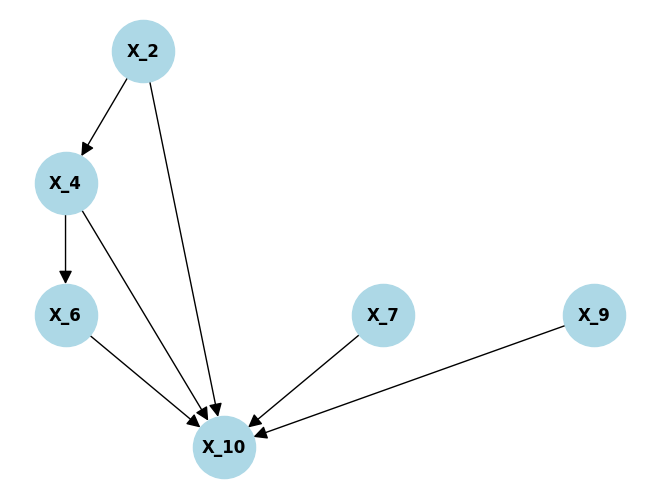

In [17]:
draw_network(ground_blanket)

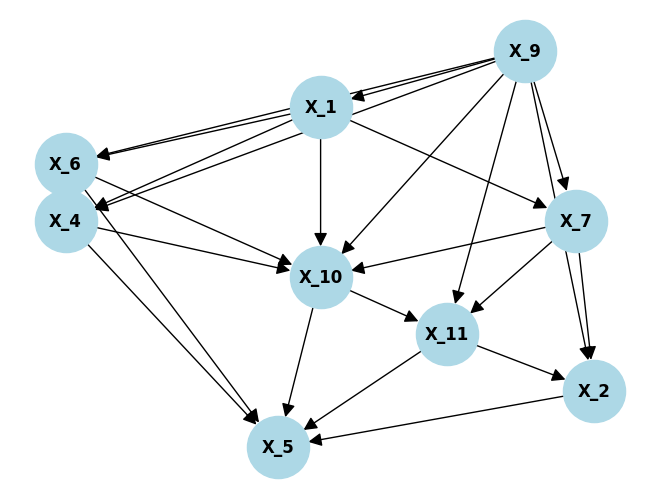

In [18]:
draw_network(generated_blanket)